In [1]:
# Import necessary packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
import altair as alt
import sys
import math
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter, save_results, load_results)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring, prim, dimensional_stacking, pairs_plotting
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.samplers
from SALib.analyze import sobol
from SALib.sample import saltelli, morris, fast_sampler
import SALib.util.results
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf
from ema_workbench.util import ema_logging
from funs_project import get_opti_policies, get_selected_policies
import time
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
from sklearn import preprocessing

# Spread plotting

To see how much the policies of an actor can affect another actor, we will take a look at the spread of the outcomes of interest in response to a specific policy across scenarios (as obtained from the synthesis).

[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\generated\genscen_Gorssel_50000_12-06-2021-03-06-15.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\generated\genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz


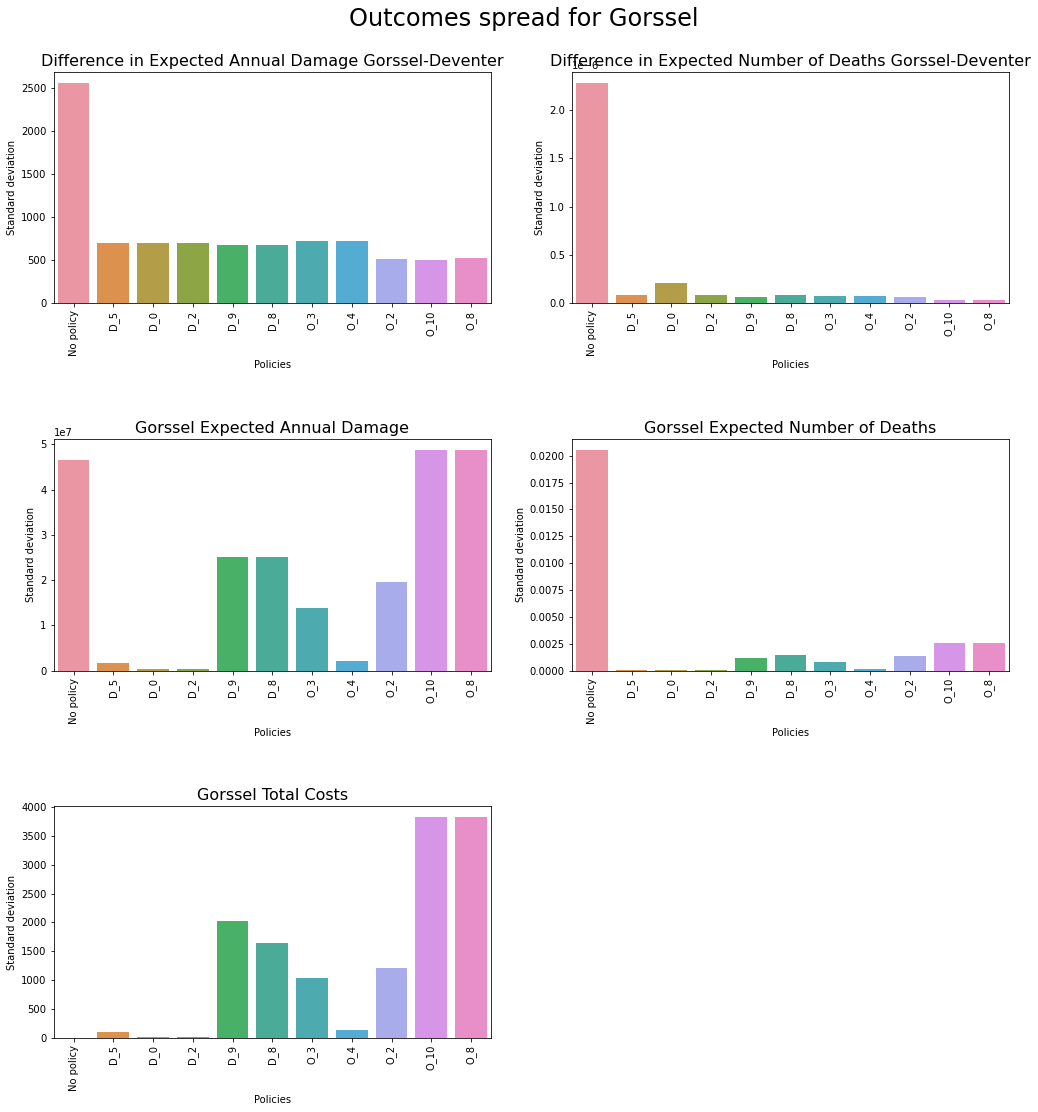

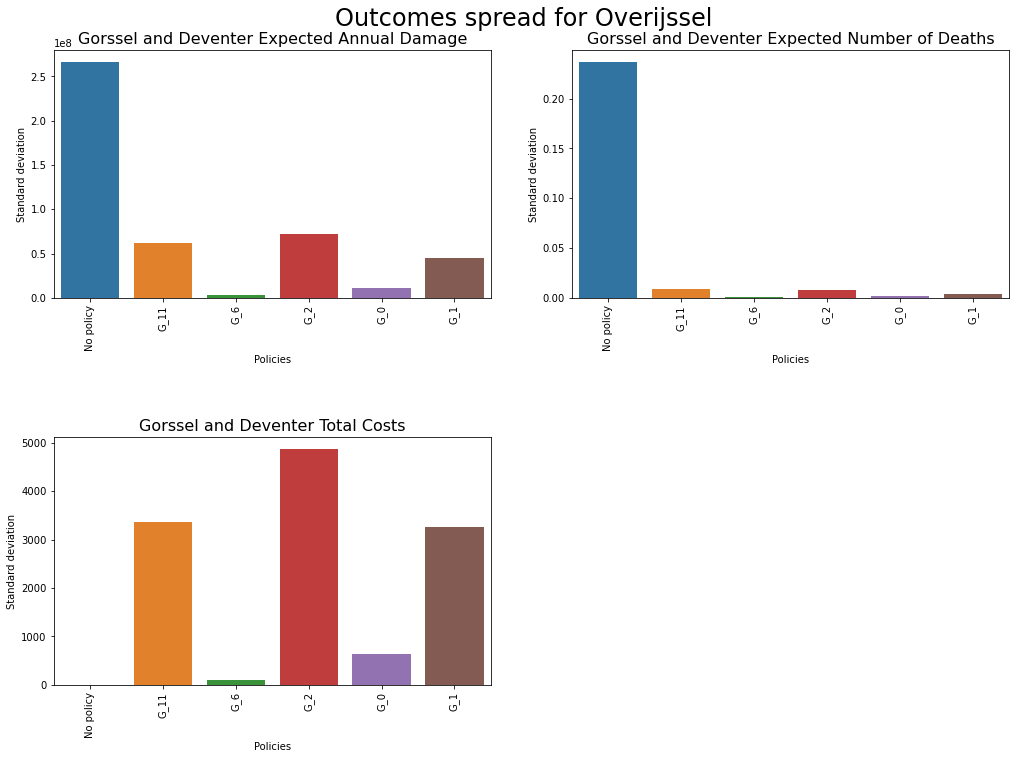

In [12]:
Gorssel = "simulation/synthesis/synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz"
Overijssel = "simulation/synthesis/synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz"

paths = {'Gorssel':Gorssel, 'Overijssel':Overijssel}
np_paths = {'Gorssel':"simulation/generated/genscen_Gorssel_50000_12-06-2021-03-06-15.tar.gz", 
            'Overijssel':"simulation/generated/genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz"}

# Map new policy names for consistency

policies_dict = {}

actors = ['Gorssel', 'Overijssel', 'Deventer']

for actor in actors:

    policies_csv = 'simulation/selected/selected_policies_Names_' + actor + '.csv'
    policies_dict_df = pd.read_csv(policies_csv)
    policies_dict_df['new_policy_name']

    for i, new_name in enumerate(policies_dict_df['new_policy_name']):
        policies_dict['Policy ' + actor + ' ' + str(i)] = new_name
        
policies_dict['Policy 0'] = 'No policy'
        
actors = ['Gorssel', 'Overijssel']

for actor in actors:
    
    # Load synthesis results for the actor
    experiments, outcomes = load_results(paths[actor])

    outcomes = pd.DataFrame(outcomes)

    # Pair the outcomes to their respective policies
    columns = list(outcomes.columns)
    columns.append('policy')
    y = pd.concat([experiments, outcomes], axis=1)[columns]
    
    no_policies = np_paths[actor]

    experiments_np, outcomes_np = load_results(no_policies)

    outcomes_np = pd.DataFrame(outcomes_np)

    y_np = pd.concat([experiments_np, outcomes_np], axis=1)[columns]
    
    y_df = pd.concat([y_np, y], axis=0)
    
    # Calculate the spread (std) of every outcome per policy
    aggregated = y_df.groupby('policy').std()
    
    # Get list of outcome names
    labels = list(outcomes.columns)

    # Get list of policy names
    policies = list(aggregated.index)

    # Calculate how many subplot rows will be needed if we plot 2 subplots per row
    plot_rows = math.ceil(len(labels)/2)

    # Initialize figure and set up
    fig, ax = plt.subplots(plot_rows,2, figsize=(14, plot_rows*5))
    plt.suptitle('Outcomes spread for ' + actor, fontsize=24)
    plt.tight_layout(h_pad=12, w_pad=5)
    fig.subplots_adjust(top=0.92)

    # Make a subplot for every outcome, where every bar represents the spread ok the outcome caused by a specific policy
    for i, outcome_name in enumerate(labels):
        data = aggregated.reset_index()
        
        sns.barplot(x='policy', y=outcome_name, data=data, ax=ax.flatten()[i])
        ax.flatten()[i].set_title(labels[i], fontsize=16)
        ax.flatten()[i].set_xticklabels([policies_dict[policy] for policy in policies], rotation=90)
        ax.flatten()[i].set_ylabel('Standard deviation')
        ax.flatten()[i].set_xlabel('Policies')



    # Hide last subplot if not needed
    if not (len(labels) % 2) == 0:    
        ax[-1, -1].axis('off')

    # Save
    plt.savefig('../../report/figures/results/spreads/outcome_spreads_' + actor + '.png', bbox_inches='tight')

[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Gorssel_10000_17-06-2021-08-58-03.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\generated\genscen_Gorssel_50000_12-06-2021-03-06-15.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\synthesis\synthesis_Overijssel_10000_17-06-2021-10-24-48.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\David2\Documents\GitHub\FabiosDecisions\epa1361\final assignment\simulation\generated\genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz


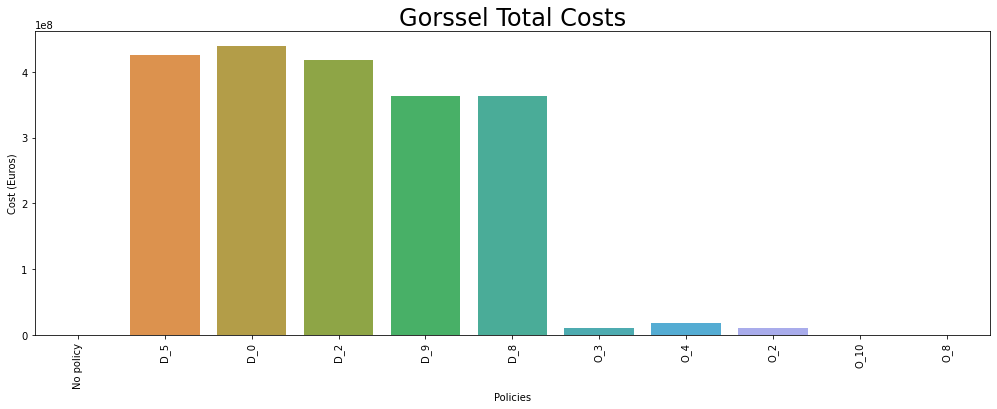

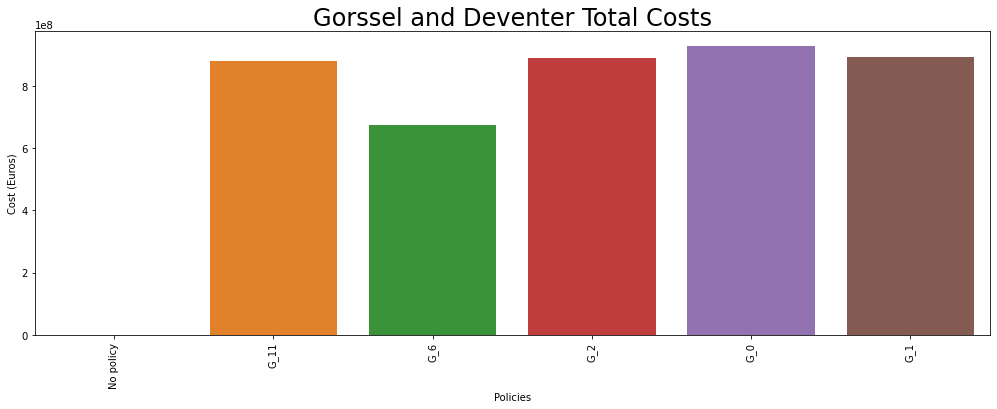

In [13]:
actors = ['Gorssel', 'Overijssel']

for actor in actors:
    
    # Load synthesis results for the actor
    experiments, outcomes = load_results(paths[actor])

    outcomes = pd.DataFrame(outcomes)

    # Pair the outcomes to their respective policies
    columns = list(outcomes.columns)
    columns.append('policy')
    y = pd.concat([experiments, outcomes], axis=1)[columns]
    
    no_policies = np_paths[actor]

    experiments_np, outcomes_np = load_results(no_policies)

    outcomes_np = pd.DataFrame(outcomes_np)

    y_np = pd.concat([experiments_np, outcomes_np], axis=1)[columns]
    
    y_df = pd.concat([y_np, y], axis=0)
    
    # Calculate the spread (std) of every outcome per policy
    aggregated = y_df.groupby('policy').mean()
    
    # Get list of outcome names
    labels = list(outcomes.columns)

    # Get list of policy names
    policies = list(aggregated.index)

    # Calculate how many subplot rows will be needed if we plot 2 subplots per row
    plot_rows = math.ceil(len(labels)/2)

    # Initialize figure and set up
    fig, ax = plt.subplots(figsize=(14, 5))
    #plt.suptitle('Outcomes spread for ' + actor, fontsize=24)
    plt.tight_layout(h_pad=12, w_pad=5)
    fig.subplots_adjust(top=0.92)

    # Make a subplot for every outcome, where every bar represents the spread ok the outcome caused by a specific policy
    
    outcome_name = labels[-1]
    
    #for i, outcome_name in enumerate(labels[-1]):
    data = aggregated.reset_index()

    sns.barplot(x='policy', y=outcome_name, data=data, ax=ax)
    ax.set_title(outcome_name, fontsize=24)
    ax.set_xticklabels([policies_dict[policy] for policy in policies], rotation=90)
    ax.set_ylabel('Cost (Euros)')
    ax.set_xlabel('Policies')



    # Hide last subplot if not needed
#     if not (len(labels) % 2) == 0:    
#         ax[-1, -1].axis('off')

    # Save
    plt.savefig('../../report/figures/results/spreads/cost_policies_' + actor + '.png', bbox_inches='tight')

In [4]:
labels = list(outcomes.columns)

In [5]:
labels[-1]

'Gorssel and Deventer Total Costs'